<a href="https://colab.research.google.com/github/Jeonyujeong/image-classification/blob/master/VGG16_1000_epochs_class_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# class 2개로 분류
normal , advanced 


# 체리 데이터 가져오기

In [ ]:
!wget https://github.com/RottenFruitsOSS/DataSet/raw/master/dataset_count_fit.tar.gz

--2020-08-18 11:05:24--  https://github.com/RottenFruitsOSS/DataSet/raw/master/dataset_cf.tar.gz
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/RottenFruitsOSS/DataSet/master/dataset_cf.tar.gz [following]
--2020-08-18 11:05:25--  https://raw.githubusercontent.com/RottenFruitsOSS/DataSet/master/dataset_cf.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5535557 (5.3M) [application/octet-stream]
Saving to: ‘dataset_cf.tar.gz’

dataset_cf.tar.gz   100%[===================>]   5.28M  --.-KB/s    in 0.1s    

2020-08-18 11:05:26 (43.2 MB/s) - ‘dataset_cf.tar.gz’ saved [5535557/5535557]



In [ ]:
!tar -xvzf dataset_count_fit.tar.gz

In [ ]:
%%shell

mkdir dataset
mv test_classification/ dataset/
mv train_classification/ dataset/

In [ ]:
%%shell

rm -r /content/dataset/test_classification/damage
rm -r /content/dataset/test_classification/spoiled_early
rm -r /content/dataset/train_classification/damage
rm -r /content/dataset/train_classification/spoiled_early

# 설정 값 정의

In [ ]:
# import the necessary packages
import os

# initialize the path to the input directory containing our dataset
# of images
DATASET_PATH = "dataset"

# initialize the class labels in the dataset
# CLASSES = ["damage", "normal", "spoiled_advanced", "spoiled_early"]
CLASSES = ["normal", "spoiled_advanced"]

# define the size of the training, validation (which comes from the
# train split), and testing splits, respectively
TRAIN_SPLIT = 0.75
VAL_SPLIT = 0.1
TEST_SPLIT = 0.25

# step size, CLR method, and number of epochs
BATCH_SIZE = 32
STEP_SIZE = 8
NUM_EPOCHS = 1000

# set the path to the serialized model after training
MODEL_PATH = os.path.sep.join(["output", "rotten_cherry.model"])

# 모듈 임포팅

In [ ]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
# matplotlib.use("Agg")

# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import cv2
import sys
import os

# 데이터 로딩과 준비
## 파일 로딩 함수

In [ ]:
def load_dataset(datasetPath):
    # grab the paths to all images in our dataset directory and initialize
    # our lists of images and class labels
    imagePaths = list(paths.list_images(datasetPath))
    data = []
    labels = []

    # loop over the image paths
    for imagePath in imagePaths:
        # extract the class label
        label = imagePath.split(os.path.sep)[-2]

        # load the image, convert it to RGB channel ordering, and resize
        # it to be a fixed 224x224 pixels, ignoring aspect ratio
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        # update the data and labels lists, respectively

        data.append(image)
        labels.append(label)

    # convert the data and labels to NumPy arrays
    return np.array(data, dtype="float32"), np.array(labels)

## 영상 데이터 파일 로딩

In [ ]:
print("[INFO] processing data...")
data, labels_ = load_dataset(DATASET_PATH)
 
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels_)

print(data.shape)
# print(labels_)
# print(labels)

plt.imshow(data[0]/255)
plt.show()

[INFO] processing data...


## 데이터 쪼개기 및 데이터 증강

In [ ]:
# TRAIN_SPLIT = 0.75
# VAL_SPLIT = 0.1
# TEST_SPLIT = 0.25

# partition the data into training and testing splits
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=TEST_SPLIT, random_state=42)

# take the validation split from the training split
(trainX, valX, trainY, valY) = train_test_split(trainX, trainY,
	test_size=VAL_SPLIT, random_state=84)

# initialize the training data augmentation object
aug = ImageDataGenerator(
	rotation_range=30,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# 모델 정의

In [ ]:
# ImageNet 데이터 셋에서 사전 학습된 VGG16 모델 조정함.

# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(CLASSES), activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False
	
# compile our model (this needs to be done after our setting our
# layers to being non-trainable
print("[INFO] compiling model...")
model.compile(loss="binary_crossentropy", optimizer='adam',
	metrics=["accuracy"])

[INFO] compiling model...


In [ ]:
stepSize = STEP_SIZE * (trainX.shape[0] // BATCH_SIZE)

# train the network
print("[INFO] training network...")
H = model.fit_generator(
	aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
	validation_data=(valX, valY),
	steps_per_epoch=trainX.shape[0] // BATCH_SIZE,
	epochs=NUM_EPOCHS,
	verbose=1)

[INFO] training network...
Epoch 1/48
20/20 [==============================] - 7s 345ms/step - loss: 6.4668 - accuracy: 0.8514 - val_loss: 6.1292 - val_accuracy: 0.9189
Epoch 2/48
20/20 [==============================] - 7s 337ms/step - loss: 5.7248 - accuracy: 0.5799 - val_loss: 4.3750 - val_accuracy: 0.5405
Epoch 3/48
20/20 [==============================] - 7s 333ms/step - loss: 5.6829 - accuracy: 0.4728 - val_loss: 6.6662 - val_accuracy: 0.0946
Epoch 4/48
20/20 [==============================] - 7s 333ms/step - loss: 5.7533 - accuracy: 0.5304 - val_loss: 5.2771 - val_accuracy: 0.7162
Epoch 5/48
20/20 [==============================] - 7s 335ms/step - loss: 5.3797 - accuracy: 0.5367 - val_loss: 5.5471 - val_accuracy: 0.2027
Epoch 6/48
20/20 [==============================] - 7s 336ms/step - loss: 5.2780 - accuracy: 0.5240 - val_loss: 6.0796 - val_accuracy: 0.0811
Epoch 7/48
20/20 [==============================] - 7s 341ms/step - loss: 5.0615 - accuracy: 0.5125 - val_loss: 3.5929 - 

In [ ]:
# evaluate the network and show a classification report
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=BATCH_SIZE)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=CLASSES))

# 모델 저장
저장한 모델을 다운받아 google 공유폴더 model에 올려주세요

In [ ]:
MODEL_PATH = "/content/output/rotten_cherry.model"

# serialize the model to disk
print("[INFO] serializing network to '{}'...".format(MODEL_PATH))
model.save(MODEL_PATH)

In [ ]:
!zip -r vgg16_1000_c2.zip ./output/*

from google.colab import files
files.download("vgg16_1000_c2.zip")

# 히스토리 확인

In [ ]:
# construct a plot that plots and saves the training history
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

# 이미지 예측

In [ ]:
from tensorflow.keras.models import load_model
from imutils import paths
from IPython.display import Image
import numpy as np
import imutils
import random
import cv2
import os
import matplotlib.pyplot as plt
from IPython.display import Image, display
from google.colab.patches import cv2_imshow

[INFO] loading model...
[INFO] predicting...
['dataset/train_classification/normal/normal_134.jpg', 'dataset/train_classification/normal/demage_201.jpg', 'dataset/train_classification/spoiled_early/advanced_655.jpg', 'dataset/train_classification/spoiled_early/early_1081.jpg', 'dataset/train_classification/spoiled_early/early_4.jpg']
output/images


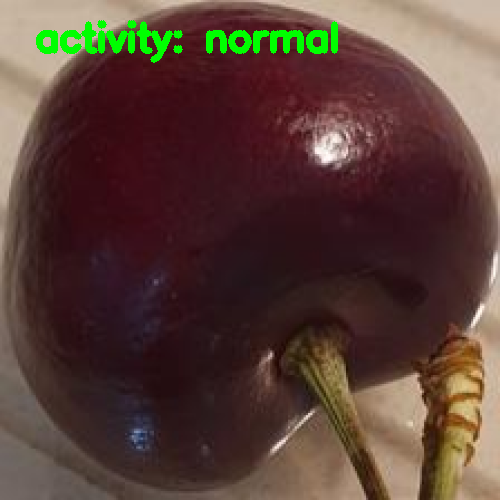

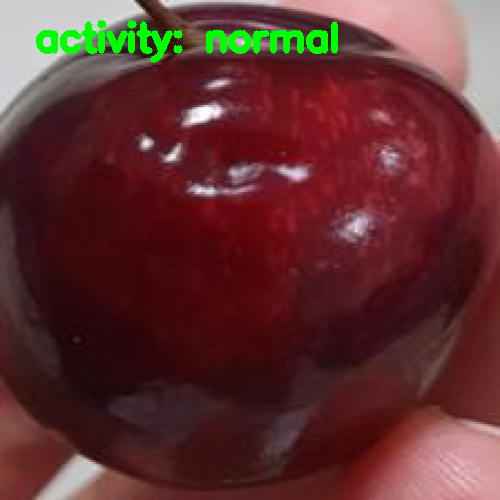

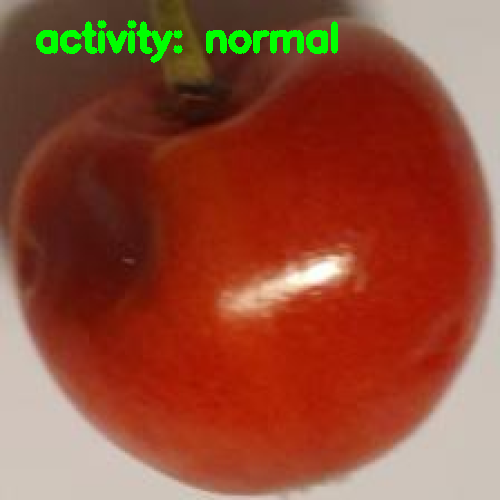

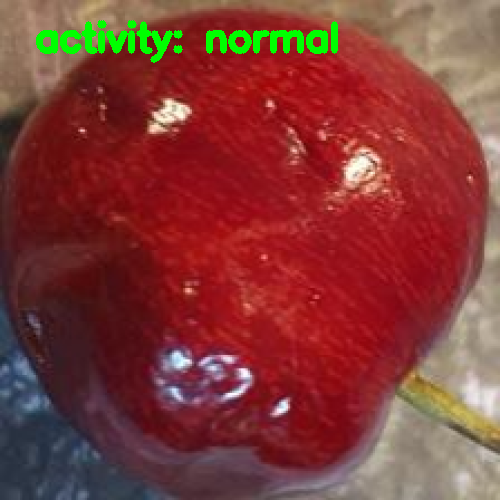

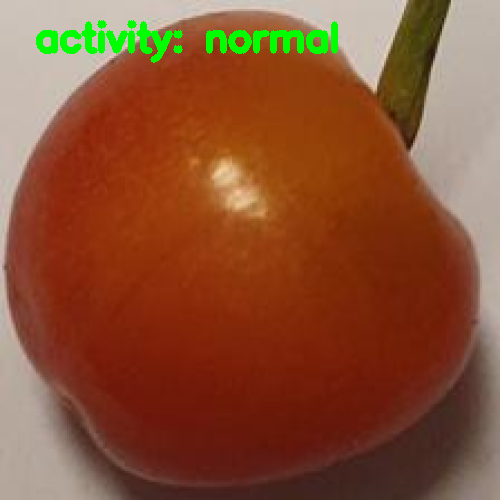

In [ ]:
!mkdir output/images

MODEL_PATH = "/content/output/rotten_cherry.model"
SAMPLE_SIZE = 5
OUTPUT_IMAGE_PATH = "output/images"

# load the trained model from disk
print("[INFO] loading model...")
# model = load_model(MODEL_PATH)

# grab the paths to the disaster images, respectively
print("[INFO] predicting...")
imagePaths = list(paths.list_images(DATASET_PATH))

# combine the two image path lists, randomly shuffle them, and sample
# them
random.shuffle(imagePaths)
imagePaths = imagePaths[:SAMPLE_SIZE]
print(imagePaths)
print(OUTPUT_IMAGE_PATH)

# loop over the sampled image paths
for (i, imagePath) in enumerate(imagePaths):
	# load the image and clone it
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (224, 224))
    output = image.copy()
 
	# resize the input image to be a fixed 128x128 pixels, ignoring
	# aspect ratio
    image = cv2.resize(image, (244, 244))
    image = image.astype("float32") / 255.0
		
	# make predictions on the image
    preds = model.predict(np.expand_dims(image, axis=0))[0]
    j = np.argmax(preds)
    label = CLASSES[j]

	# draw the activity on the output frame
    text = "activity: {}".format(label)
    output = imutils.resize(output, width=500)
    cv2.putText(output, text, (35, 50), cv2.FONT_HERSHEY_SIMPLEX,
		1.25, (0, 255, 0), 5)

	# write the output image to disk	 
    filename = "{}.png".format(i)
    p = os.path.sep.join([OUTPUT_IMAGE_PATH, filename])
    cv2_imshow(output)
    cv2.imwrite(p, output)

In [ ]:
!rm -r output/images/
!mkdir output/images/

In [ ]:
!zip -r output.zip ./output/*

updating: output/clr_plot.png (deflated 4%)
updating: output/images/ (stored 0%)
updating: output/images/0.png (deflated 14%)
updating: output/images/3.png (deflated 13%)
updating: output/images/4.png (deflated 7%)
updating: output/images/1.png (deflated 12%)
updating: output/images/2.png (deflated 14%)
updating: output/lrfind_plot.png (deflated 5%)
updating: output/rotten_cherry.model/ (stored 0%)
updating: output/rotten_cherry.model/variables/ (stored 0%)
updating: output/rotten_cherry.model/variables/variables.data-00000-of-00001 (deflated 34%)
updating: output/rotten_cherry.model/variables/variables.index (deflated 67%)
updating: output/rotten_cherry.model/saved_model.pb (deflated 91%)
updating: output/rotten_cherry.model/assets/ (stored 0%)
updating: output/training_plot.png (deflated 4%)


In [ ]:
from google.colab import files
files.download("output.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 모델 로드

In [ ]:
# import the necessary packages
from tensorflow.keras.models import load_model
from collections import deque
import numpy as np
import argparse
import cv2

In [ ]:
# load the trained model from disk
print("[INFO] loading model and label binarizer...")
model = load_model(MODEL_PATH)

[INFO] loading model and label binarizer...
